In [1]:
import os
import sys
import argparse

print(os.getcwd())
os.chdir("../../")
os.getcwd()

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

/data01/dl23vitcas/dl_project/src/single_task_object_detection
config/single_task_object_detection.yaml


In [2]:
from config_experiments import config
from torchvision.transforms import transforms
from dataloader import VOC08Attr
import matplotlib.pyplot as plt
from model import ObjectDetectionModel
from utils import set_device
import torch
from bbox_transform import resize_bounding_boxes, apply_nms
import matplotlib.patches as patches
import torchvision

In [3]:
transform_val = transform = transforms.Compose(
    [
        transforms.Resize(
            size=config["transform"]["resize_values"],
            max_size=config["transform"]["max_size"],
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [4]:
# model_path = "../dl_project/experiments/object_detection/2024-07-25_10-51-08/models/best_model_epoch_95.pth"
model_path = "../dl_project/experiments/object_detection/2024-07-28_19-23-43/models/model_epoch_75.pth"

device = set_device(config["global"]["gpu_id"])
model = ObjectDetectionModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [5]:
val_data = VOC08Attr(train=False, transform=None)
val_data_for_model = VOC08Attr(train=False, transform=transform_val)

In [6]:
def inference(idx):
    img_transform, img_size_orig_transform, _, _, _, ss_rois_transform = (
        val_data_for_model[idx]
    )
    image, img_size_orig, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    ss_rois_transform = ss_rois_transform.to(device)

    indices_batch = torch.zeros(ss_rois_transform.shape[0], device=device).unsqueeze(-1)

    cls_max_score_net, max_score_net, bboxs_net = model.prediction_img(
        img_transform, ss_rois_transform, indices_batch
    )

    bboxs_net = resize_bounding_boxes(
        bboxs_net,
        orig_size=(img_transform.shape[3], img_transform.shape[2]),
        new_size=img_size_orig_transform,
    )

    pred_bbox, pred_class, pred_score = apply_nms(
        cls_max_score_net, max_score_net, bboxs_net
    )
    pred_bbox, pred_class, pred_score = (
        pred_bbox.cpu(),
        pred_class.cpu(),
        pred_score.cpu(),
    )
    return image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score

In [7]:
def plot_inference(image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score):
    im = image
    fig, ax = plt.subplots()
    ax.imshow(im)

    for gt_el in gt_bbox:
        x_min, y_min, x_max, y_max = gt_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

    for pred_el in pred_bbox:
        x_min, y_min, x_max, y_max = pred_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    print("NET")
    for box, c, score in zip(pred_bbox, pred_class, pred_score):
        print(
            f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]}) \tscore: {score.item():.3f}"
        )

    print("\nGT")

    for box, c in zip(gt_bbox, gt_class):
        print(f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})")
    plt.show()

IDX: 423

NET
tensor([135,  68, 412, 375], dtype=torch.int32) 	 class: 2 (person) 	score: 0.999
tensor([  0, 145,  56, 290], dtype=torch.int32) 	 class: 2 (person) 	score: 0.921
tensor([ 75, 339, 107, 365], dtype=torch.int32) 	 class: 3 (bottle) 	score: 0.772

GT
tensor([171,  58, 418, 375], dtype=torch.int32) 	 class: 2 (person)
tensor([  1, 138, 102, 375], dtype=torch.int32) 	 class: 2 (person)
tensor([ 28, 343, 107, 375], dtype=torch.int32) 	 class: 3 (bottle)


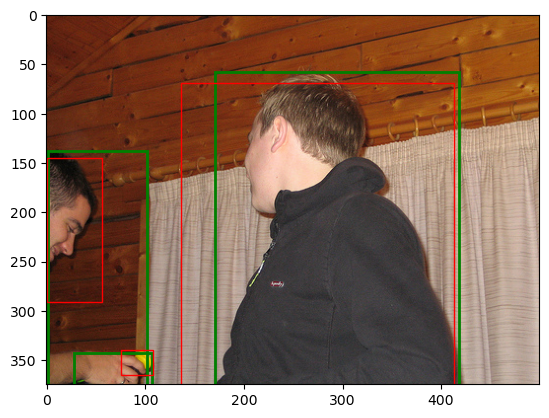

In [23]:
idx = torch.randint(low=0, high=len(val_data), size=(1,))

print(f"IDX: {idx.item()}\n")
image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score = inference(idx=idx)
plot_inference(image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score)

tensor([1933, 2126,  282, 1644,  867, 1789, 1055, 2167])


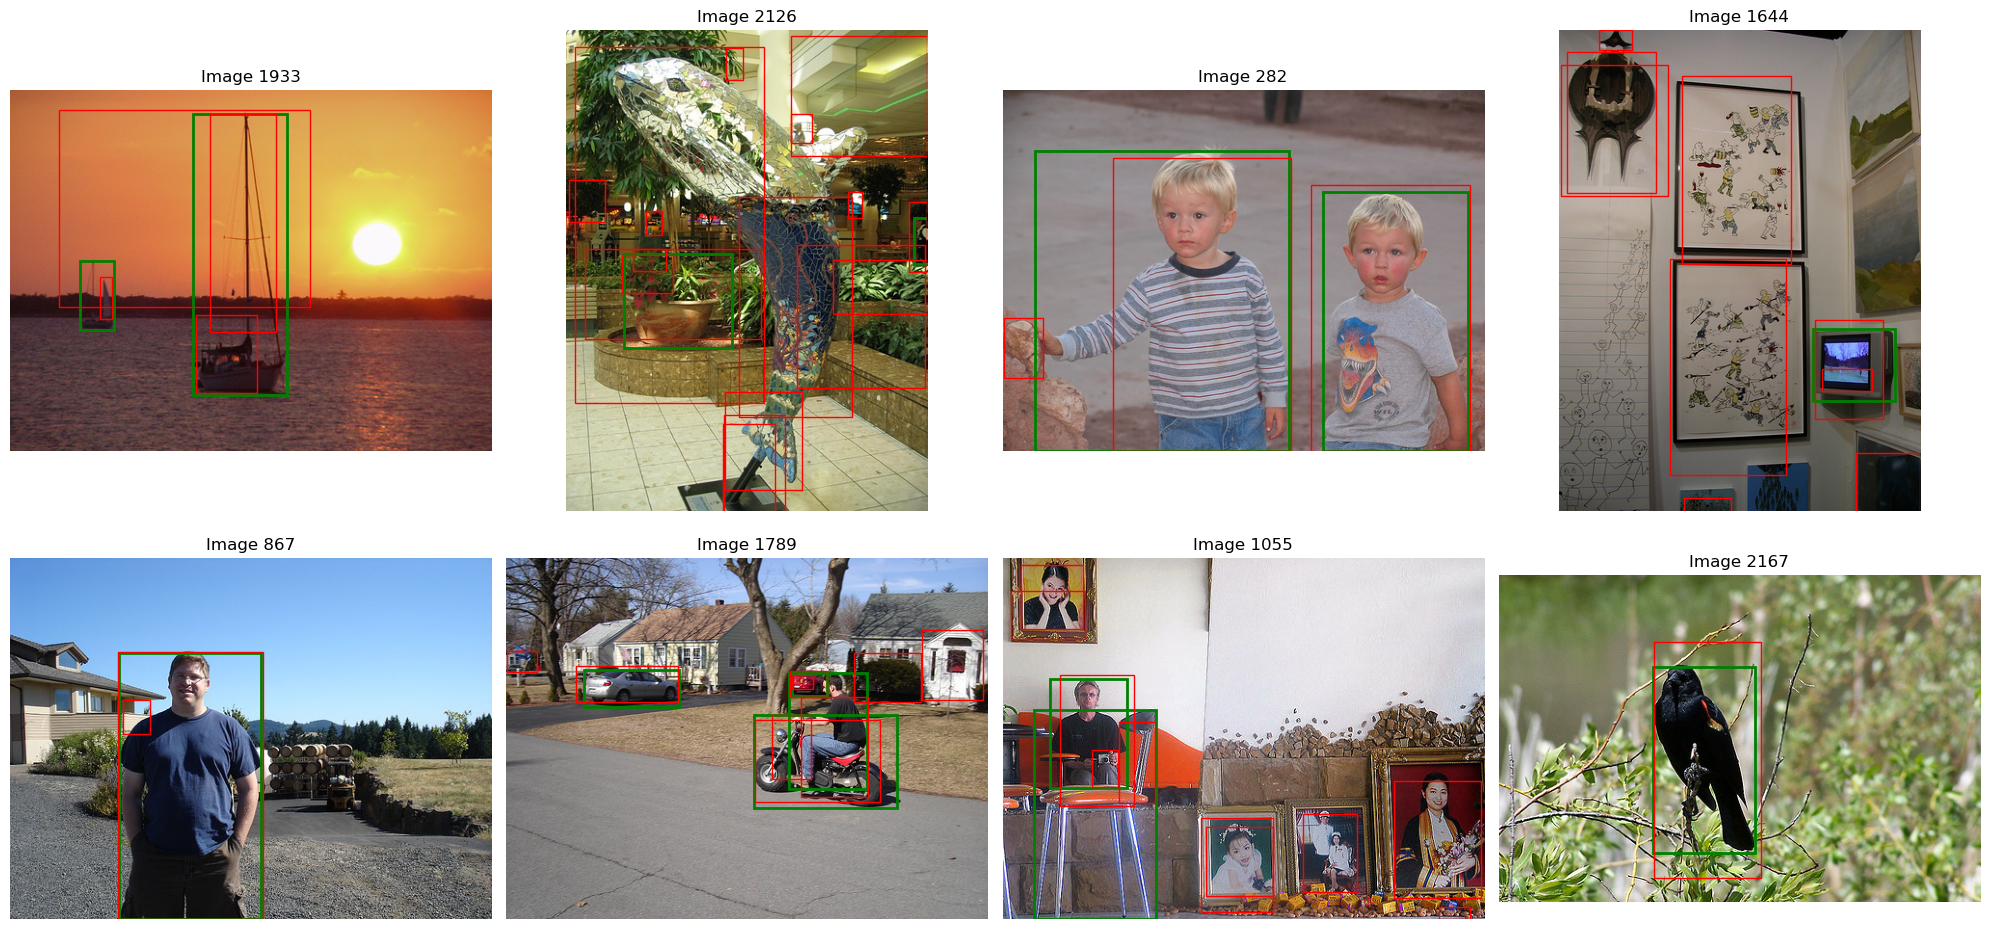

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def inference(idx):
    img_transform, img_size_orig_transform, _, _, _, ss_rois_transform = (
        val_data_for_model[idx]
    )
    image, img_size_orig, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    ss_rois_transform = ss_rois_transform.to(device)

    indices_batch = torch.zeros(ss_rois_transform.shape[0], device=device).unsqueeze(-1)

    cls_max_score_net, max_score_net, bboxs_net = model.prediction_img(
        img_transform, ss_rois_transform, indices_batch
    )

    bboxs_net = resize_bounding_boxes(
        bboxs_net,
        orig_size=(img_transform.shape[3], img_transform.shape[2]),
        new_size=img_size_orig_transform,
    )

    pred_bbox, pred_class, pred_score = apply_nms(
        cls_max_score_net, max_score_net, bboxs_net
    )
    pred_bbox, pred_class, pred_score = (
        pred_bbox.cpu(),
        pred_class.cpu(),
        pred_score.cpu(),
    )
    return image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score


def plot_inference_multiple(images_data, indices):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 righe, 4 colonne
    axs = axs.ravel()  # per iterare facilmente sugli assi

    for i, (image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score) in enumerate(
        images_data
    ):
        ax = axs[i]
        ax.imshow(image)

        for gt_el in gt_bbox:
            x_min, y_min, x_max, y_max = gt_el
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

        for pred_el in pred_bbox:
            x_min, y_min, x_max, y_max = pred_el
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

        ax.set_title(f"Image {indices[i]}")
        ax.axis("off")  # Nascondi assi

        """
        print(f"Image {i + 1} - NET")
        for box, c, score in zip(pred_bbox, pred_class, pred_score):
            print(
                f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]}) \tscore: {score.item():.3f}"
            )

        print(f"\nImage {i + 1} - GT")
        for box, c in zip(gt_bbox, gt_class):
            print(
                f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})"
            )
        """
    plt.tight_layout()
    plt.show()


# Seleziona 8 indici casuali dal dataset di validazione
indices = torch.randint(low=0, high=len(val_data), size=(8,))
print(indices)

# Esegui inferenza e colleziona i risultati
images_data = [inference(idx.item()) for idx in indices]

# Plot dei risultati
plot_inference_multiple(images_data, indices)